## 1.0 Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2.0 Load the dataset

In [7]:
df = pd.read_csv(r'dataset/data.csv')

## 3.0 Preparing the dataset

### 3.1 Renaming the columns

In [8]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

### 3.2 Normalizing string values

In [10]:
string_columns = list(df.dtypes[df.dtypes=='object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

## 4.0 Target variable analysis

### 4.1 Target variable visualization

Text(0.5, 1.0, 'MSRP distribution (only MSRP<10e4)')

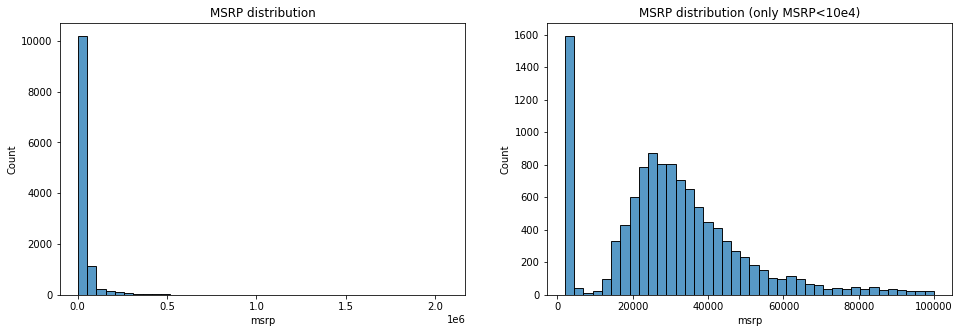

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

col = 'msrp'

sns.histplot(x=col, data=df, ax=ax[0], bins=40)
sns.histplot(x=col, data=df[df[col]<10e4], ax=ax[1], bins=40);

ax[0].set_title('MSRP distribution')
ax[1].set_title('MSRP distribution (only MSRP<10e4)')

### 4.2 Target variable transformation

In [22]:
log_price = np.log1p(df['msrp'])

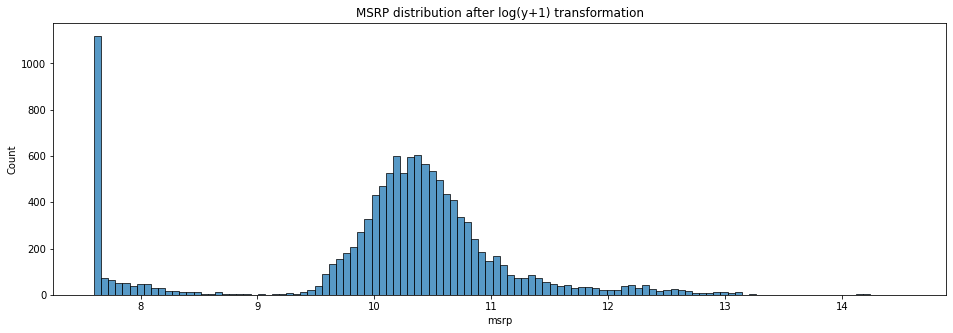

In [26]:
plt.subplots(figsize=(16,5))
sns.histplot(log_price)
plt.title('MSRP distribution after log(y+1) transformation');

## 5.0 Checking for missing values

In [27]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## 6.0 Validation framework

### 6.1 Train, validation, test data split

In [28]:
n = len(df)

In [29]:
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val + n_test)

In [32]:
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

In [34]:
df_shuffled = df.iloc[idx]

In [36]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

### 6.2 Log transformation

In [37]:
y_train = np.log1p(df_train['msrp'].values)
y_val = np.log1p(df_val['msrp'].values)
y_test = np.log1p(df_test['msrp'].values)

In [38]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

## 7.0 Machine learning for regression

### 7.1 Linear Regression (Normal Equations)

In [39]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

### 7.2 Predicting the price

#### 7.2.1 Baseline solution

* Feature selection

In [40]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

* Replace NAN values with zero

In [41]:
df_num = df_num.fillna(0)

* Training the LR model

In [43]:
X_train = df_num.values
w_0, w = train_linear_regression(X_train, y_train)

* Make predictions

In [44]:
y_pred = w_0 + X_train.dot(w)

* Predictions Analisys

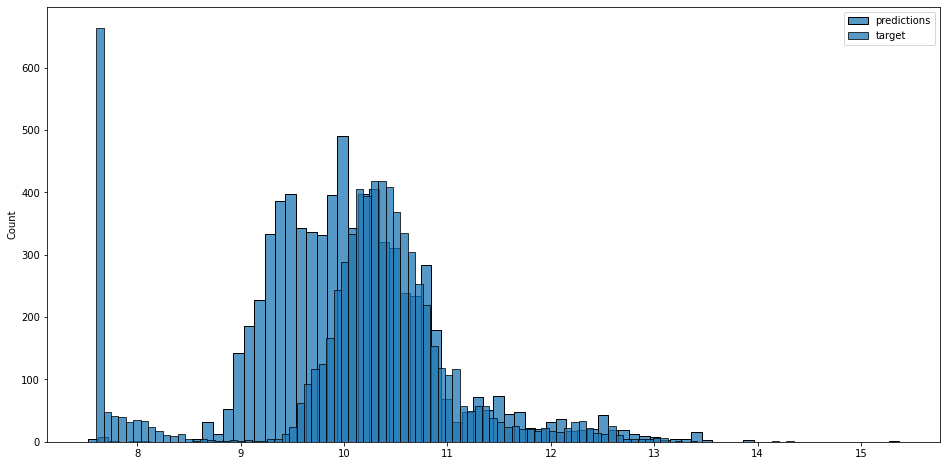

In [48]:
plt.subplots(figsize=(16,8))

sns.histplot(y_pred, label='predictions')
sns.histplot(y_train, label='target')

plt.legend();

### 7.3 RMSE

In [49]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [51]:
rmse(y_train, y_pred)

0.7570200472453602

### 7.4 Validating the model

In [52]:
df_num = df_val[base]
df_num = df_num.fillna(0)
X_val = df_num.values

In [53]:
y_pred = w_0 + X_val.dot(w)

In [54]:
rmse(y_val, y_pred)

0.7398184285113428

In [62]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [63]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation:', rmse(y_val, y_pred))

validation: 0.7398184285113428


### 7.5 Feature engineering

#### 7.5.1 year

In [66]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = df['year'].max() - df['year']
    features.append('age')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    X = df_num.values
    
    return X

In [67]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation:', rmse(y_val, y_pred))

validation: 0.5133241025826359


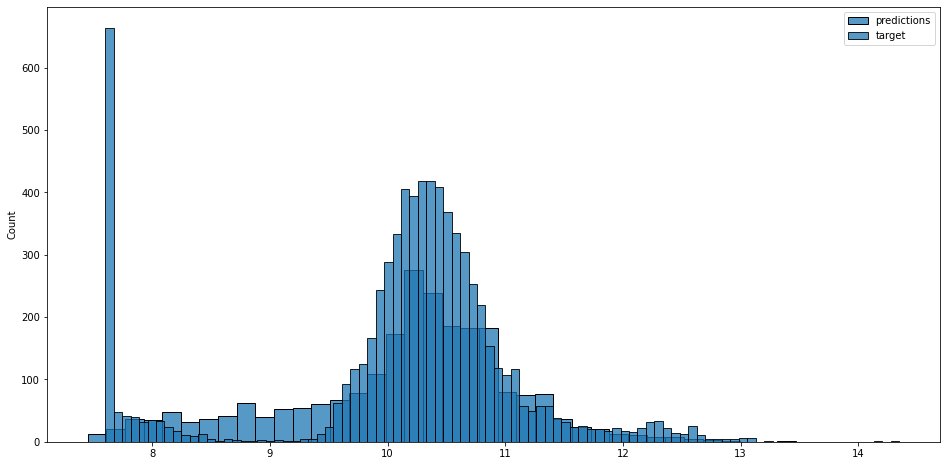

In [68]:
plt.subplots(figsize=(16,8))

sns.histplot(y_pred, label='predictions')
sns.histplot(y_train, label='target')

plt.legend();

#### 7.5.2 number_of_doors

In [95]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = df['year'].max() - df['year']
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        value = (df['number_of_doors'] == v).astype(int)
        df[feature] = value
        features.append(feature)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    X = df_num.values
    
    return X

In [96]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation:', rmse(y_val, y_pred))

validation: 0.5108230515529392


#### 7.5.3 make

In [97]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = df['year'].max() - df['year']
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        value = (df['number_of_doors'] == v).astype(int)
        df[feature] = value
        features.append(feature)
    
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        value = (df['make'] == v).astype(int)
        df[feature] = value
        features.append(feature)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    X = df_num.values
    
    return X

In [98]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation:', rmse(y_val, y_pred))

validation: 0.5015149550252865


#### 7.5.4 Other categorical features

In [105]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = df['year'].max() - df['year']
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        df[feature] = value
        features.append(feature)
    
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    
    for v in ['regular_unleaded', 'premium_unleaded_(required)', 'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']: 
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
    
    for v in ['automatic', 'manual', 'automated_manual']: 
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']: 
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']: 
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']: 
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible','4dr_hatchback']: 
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    X = df_num.values
    
    return X

In [106]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation:', rmse(y_val, y_pred))

validation: 1.3841211148114038e+17


### 7.6 Regularization

In [109]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [110]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

    0, 1000149804895825408.00, 116.06, -119342500096694592.00
0.001, 6.78, -0.10, 1.72
 0.01, 6.77, -0.10, 1.72
  0.1, 6.73, -0.10, 1.71
    1, 6.39, -0.09, 1.62
   10, 4.95, -0.07, 1.23


In [112]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation:', rmse(y_val, y_pred))

validation: 0.46188191579175897


In [113]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.4618827430061624
0.0001 0.46188295815626407
 0.001 0.46188191579175897
  0.01 0.46187164709536266
   0.1 0.46177941395197175
     1 0.46163676518449226
     5 0.4665701803295658
    10 0.4742061344140193


In [115]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=1)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.46163676518449226
test: 0.45767259742637967


### 7.7 Making predictions

In [116]:
ad = {
    'city_mpg': 18,
    'driven_wheels': 'all_wheel_drive',
    'engine_cylinders': 6.0,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'highway_mpg': 25,
    'make': 'toyota',
    'market_category': 'crossover,performance',
    'model': 'venza',
    'number_of_doors': 4.0,
    'popularity': 2031,
    'transmission_type': 'automatic',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon',
    'year': 2013
}

In [117]:
df_test = pd.DataFrame([ad])
X_test = prepare_X(df_test)

In [118]:
y_pred = w_0 + X_test.dot(w)

In [120]:
suggestion = np.expm1(y_pred)
suggestion

array([34910.79729682])